## Importing Libraries

In [37]:
import pandas as pd 
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline

## Exploring the Data

#### Reviewing SqlConnection, Columns & Values

In [2]:
conn = sql.connect("factbook.db")
q = "Select * From sqlite_master Where type = 'table';"
pd.read_sql_query(q,conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


In [3]:
q1 = "Select * from facts" 
facts = pd.read_sql_query(q1, conn)
facts.columns

Index(['id', 'code', 'name', 'area', 'area_land', 'area_water', 'population',
       'population_growth', 'birth_rate', 'death_rate', 'migration_rate'],
      dtype='object')

In [4]:
facts.head(5)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230.0,652230.0,0.0,32564342.0,2.32,38.57,13.89,1.51
1,2,al,Albania,28748.0,27398.0,1350.0,3029278.0,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741.0,2381741.0,0.0,39542166.0,1.84,23.67,4.31,0.92
3,4,an,Andorra,468.0,468.0,0.0,85580.0,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700.0,1246700.0,0.0,19625353.0,2.78,38.78,11.49,0.46


## Calculating Summary Statistics

In [5]:
q_sum = "Select MIN(population), MAX(population), MIN(population_growth), MAX(population_growth) from facts"
summary_stats = pd.read_sql_query(q_sum, conn)
summary_stats


,MIN(population),MAX(population),MIN(population_growth),MAX(population_growth)
0,0,7256490011,0.0,4.02


A few things stick out from the summary statistics in the last screen:

- there's a country with a population of 0
- there's a country with a population of 7256490011 (or more than 7.2 billion people)

Let's zoom in on just these countries.



#### Country with Population equal to 0

In [6]:
q_0 = "Select name, MIN(population) from facts where population = (select MIN(population) from facts)"
min_pop_country = pd.read_sql_query(q_0, conn)
min_pop_country

,name,MIN(population)
0,Antarctica,0


We notice that the name of country whose population is equal to 0 is "Antartica", which is fairly reasonable, due to its adverse weather conditions. Nevertheless, it would be interesting to understand what geographic boundries are used to classify Antartica.

If we review the CIA Factbook page for Antartica we notice that they state that "No indigenous inhabitants are found, but there are both permanent and summer-only staffed research stations". 

This should solve our prior concern of the estimate being wrong to a possible boundray mistake.


#### Country with Population higher than 7.2Bn

In [7]:
q2 = "Select name, MAX(population) from facts where population = (select MAX(population) from facts)"
max_pop_country = pd.read_sql_query(q2, conn)
max_pop_country

,name,MAX(population)
0,World,7256490011


We notice that the name of country whose population is higher than 7.2Bn is "World". This also is fairly reasonable as the current world population is around 7.2Bn-7.4Bn depending on what source we use. 

## Visualsing Distributions of non-outlier countries

Focusing on Population, Population Growth, Birth Rate and Death Rate

In [8]:
q3 = "Select population, population_growth, birth_rate, death_rate from facts where name not in('Antartica', 'World')"
results = pd.read_sql_query(q3, conn)
results.head(5)

,population,population_growth,birth_rate,death_rate
0,32564342.0,2.32,38.57,13.89
1,3029278.0,0.30,12.92,6.58
2,39542166.0,1.84,23.67,4.31
3,85580.0,0.12,8.13,6.96
4,19625353.0,2.78,38.78,11.49


#### Plotting Histogram

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a253fb908>,
      dtype=object)

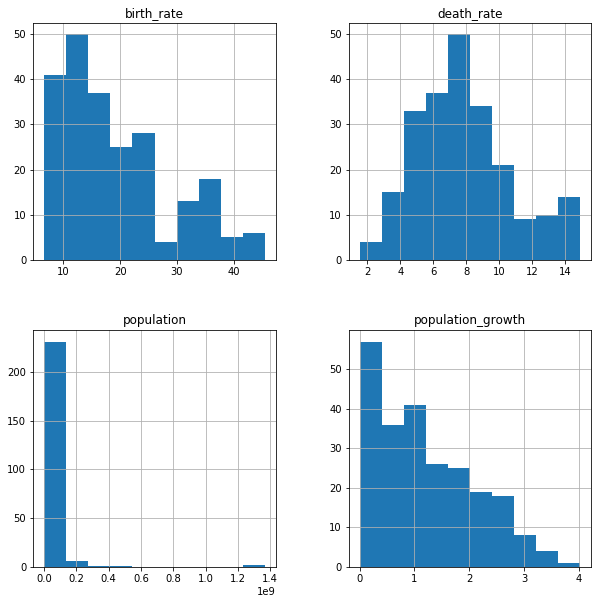

In [36]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
results.hist(ax=ax)

#### Plotting Histogram & Distribution Matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111ea02b0>,
      dtype=object)

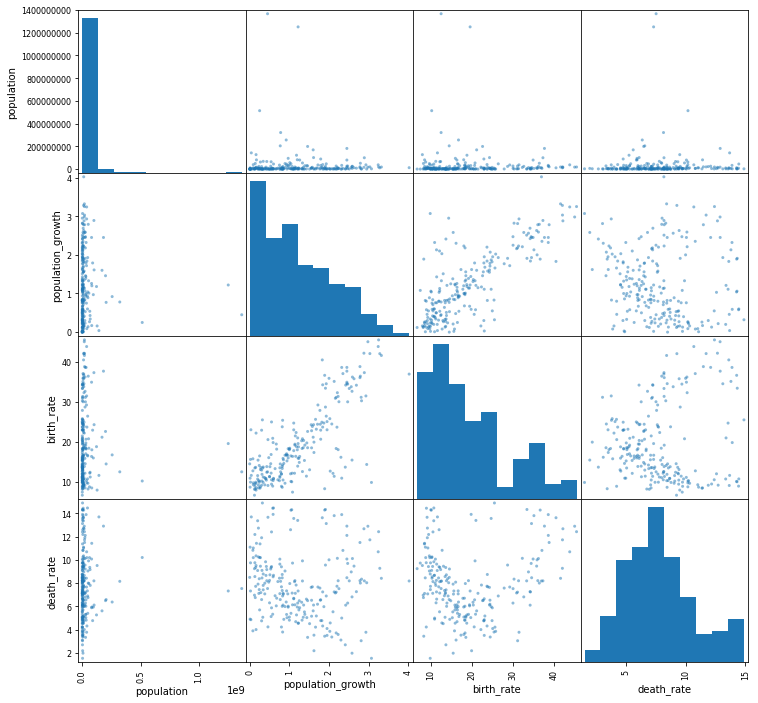

In [38]:
pd.plotting.scatter_matrix(results[['population', 'population_growth', "birth_rate", "death_rate"]], figsize=(12,12))

## Further Examination

- Q1 =  Which countries have the highest population density?
- Q2 = Which countries have the highest ratios of water to land?
- Q3 = Which countries have more water than land?

### Q1
#### We define population density as:
$PD= Population/AreaSurface$

In [100]:
Q1 = "Select name, cast(population as float) as 'population', cast(area_land as float) as 'area' from facts where (population > 0.0) AND (area> 0.0)"
Q_1 = pd.read_sql_query(Q1, conn)
Q_1. head(5)

,name,population,area
0,Afghanistan,32564342.0,652230.0
1,Albania,3029278.0,27398.0
2,Algeria,39542166.0,2381741.0
3,Andorra,85580.0,468.0
4,Angola,19625353.0,1246700.0


We excluded all the values that are 0 because it is impossible to calculate the ratio for countries that do not have any population and because countries that have area_land = 0 do not exist in this worls (if not they would not be classified as countries)

In [102]:
Q_1["pd"] = Q_1["population"]/ Q_1["area"]
print(Q_1.tail(5), Q_1.head(5))

               name  population      area           pd
231     Puerto Rico   3598357.0    8870.0   405.677227
232  Virgin Islands    103574.0     346.0   299.346821
233      Gaza Strip   1869055.0     360.0  5191.819444
234       West Bank   2785366.0    5640.0   493.859220
235  Western Sahara    570866.0  266000.0     2.146113           name  population       area          pd
0  Afghanistan  32564342.0   652230.0   49.927697
1      Albania   3029278.0    27398.0  110.565662
2      Algeria  39542166.0  2381741.0   16.602211
3      Andorra     85580.0      468.0  182.863248
4       Angola  19625353.0  1246700.0   15.741841


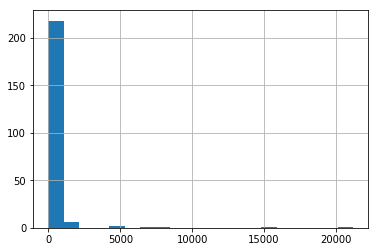

In [105]:
Q_1["pd"].hist(bins = 20)

Majority of the Countries have a Population Denisty Ratio between 0-5000.

In [110]:
Q_1.sort_values("pd", ascending = False).head()

,name,population,area,pd
198,Macau,592731.0,28.0,21168.964286
115,Monaco,30535.0,2.0,15267.500000
153,Singapore,5674472.0,687.0,8259.784571
197,Hong Kong,7141106.0,1073.0,6655.271202
233,Gaza Strip,1869055.0,360.0,5191.819444


The 5 countries that have the highest Population Density are: 
    1. Macau
    2. Monaco
    3. Singapore
    4. Hong Kong
    5. Gaza Strip

### Q2
#### We define Ratios of Water to Land as:
$WLR = Water Area/Land Area$

In [80]:
Q2 = "Select name, cast(area_water as float) as 'area_water', cast(area_land as float) as 'area_land' from facts where (area_water > 0.0) AND (area_land > 0.0)"
Q_2 = pd.read_sql_query(Q2, conn)
print(Q_2.tail(5), Q_2.head(5))

                               name  area_water  area_land
147                   New Caledonia       300.0    18275.0
148  British Indian Ocean Territory     54340.0       60.0
149                     Puerto Rico      4921.0     8870.0
150                  Virgin Islands      1564.0      346.0
151                       West Bank       220.0     5640.0         name  area_water  area_land
0    Albania      1350.0    27398.0
1  Argentina     43710.0  2736690.0
2    Armenia      1540.0    28203.0
3  Australia     58920.0  7682300.0
4    Austria      1426.0    82445.0


In [83]:
Q_2["wlr"] = Q_2["area_water"] / Q_2["area_land"]
Q_2.head()

,name,area_water,area_land,wlr
0,Albania,1350.0,27398.0,0.049274
1,Argentina,43710.0,2736690.0,0.015972
2,Armenia,1540.0,28203.0,0.054604
3,Australia,58920.0,7682300.0,0.007670
4,Austria,1426.0,82445.0,0.017296


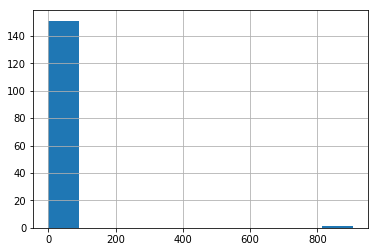

In [87]:
Q_2["wlr"].hist(bins = 10)

We notice that nearly the whole dataset contains countries that have a WLR 0 - 200. Nevertheless a small group of countries seems to have a ratio that is higher than 800. Let's investigate if these results are right.

In [92]:
Q_2.sort_values("wlr", ascending = False).head(5)

,name,area_water,area_land,wlr
148,British Indian Ocean Territory,54340.0,60.0,905.666667
150,Virgin Islands,1564.0,346.0,4.520231
149,Puerto Rico,4921.0,8870.0,0.554791
6,"Bahamas, The",3870.0,10010.0,0.386613
53,Guinea-Bissau,8005.0,28120.0,0.284673


The only two countries that have a ratio higher than 1. This suggest that the above-shown distribution leads us to erroneous conclusions. Hence, we will drop the two countries (British Indian Ocean Territory	, Virgin Islands) and see if the distibution changes.

In [98]:
Q2_ex = Q_2[(Q_2["name"] != "Virgin Islands") &(Q_2["name"] != "British Indian Ocean Territory")]
Q2_ex.sort_values("wlr", ascending = False).head(5)

,name,area_water,area_land,wlr
149,Puerto Rico,4921.0,8870.0,0.554791
6,"Bahamas, The",3870.0,10010.0,0.386613
53,Guinea-Bissau,8005.0,28120.0,0.284673
81,Malawi,24404.0,94080.0,0.259396
93,Netherlands,7650.0,33893.0,0.225710


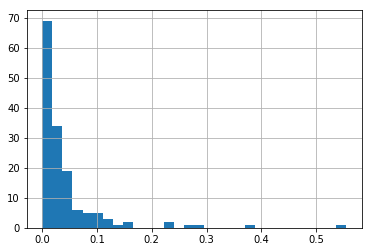

In [97]:
Q2_ex["wlr"].hist(bins =30)

The new distibution showcases a far more accurate distibution. In this plot we see that the overall distibution of countries strongly positivley skewed, but not as strong as the previous plot.

#### Q3 - Which countries Have more Water than Land?

From our earlier analysis the only countries that have more water than land are British Indian Ocean Territory and Virgin Islands 

In [112]:
Q_2.sort_values("wlr", ascending = False).head(5)

,name,area_water,area_land,wlr
148,British Indian Ocean Territory,54340.0,60.0,905.666667
150,Virgin Islands,1564.0,346.0,4.520231
149,Puerto Rico,4921.0,8870.0,0.554791
6,"Bahamas, The",3870.0,10010.0,0.386613
53,Guinea-Bissau,8005.0,28120.0,0.284673
